```Python
Solves the incompressible Navier Stokes equations using "Stable Fluids" by Jos Stam
in a closed box with a forcing that creates a bloom. 


Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0


u:  Velocity (2d vector)
p:  Pressure
f:  Forcing
ν:  Kinematic Viscosity
ρ:  Density
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator


----

A closed box


                                    u = 0
                                    v = 0 

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0

* Homogeneous Dirichlet Boundary Condictio

----- 

Forcing Function

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
            |      *                             *            |
            |                             *                   | 
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *           ^ ^ ^ ^ ^ ^                    |
            |           *      | | | | | |                 *  |
        0.2 |                  | | | | | |     *           *  |
            |                  | | | | | |             *      |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

-> Upwards pointing force in the lower center of the domain.


-----

Solution Strategy:

-> Start with zero velocity everywhere: u = [0, 0]

1. Add forces

    w₁ = u + Δt f

2. Convect by self-advection (set the value at the current
   location to be the value at the position backtraced
   on the streamline.) -> unconditionally stable

    w₂ = w₁(p(x, −Δt))

3. Diffuse implicitly (Solve a linear system matrix-free
   by Conjugate Gradient) -> unconditionally stable

    (I − ν Δt ∇²)w₃ = w₂

4.1 Compute a pressure correction (Solve a linear system
    matrix-free by Conjugate gradient)

    ∇² p = ∇ ⋅ w₃

4.2 Correct velocities to be incompressible

    w₄ = w₃ − ∇p

5. Advance to next time step

    u = w₄ 


-> The Boundary Conditions are prescribed indirectly using
   the discrete differential operators.

-----

The solver is unconditionally stable, hence all parameters can be
chosen arbitrarily. Still, be careful that too high timesteps can
make the advection step highly incorrect.
```

In [1]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt

import cmasher as cmr
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
DOMAIN_SIZE = 1.0
N_POINTS = 41
N_TIME_STEPS = 100
TIME_STEP_LENGTH = 0.1

KINEMATIC_VISCOSITY = 0.0001

MAX_ITER_CG = None

In [3]:
def forcing_function(time, point):
    time_decay = np.maximum(
        2.0 - 0.5 * time,
        0.0,
    )
    
    forced_value = (
        time_decay
        *
        np.where(
            (
                (point[0] > 0.4)
                &
                (point[0] < 0.6)
                &
                (point[1] > 0.1)
                &
                (point[1] < 0.3)
            ),
            np.array([0.0, 1.0]),
            np.array([0.0, 0.0]),
        )
    )
    return forced_value
    
def advect(field, vector_field):
    backtraced_positions = np.clip(
        (
            coordinates
            -
            TIME_STEP_LENGTH
            *
            vector_field
        ),
        0.0,
        DOMAIN_SIZE,
    )
    
    advected_field = interpolate.interpn(
        points = (x,y),
        values = field,
        xi = backtraced_positions,
    )
    
    return advected_field

def laplace(field):
    diff = np.zeros_like(field)
    
    diff[1:-1, 1:-1] = (
        (
            field[0:-2, 1:-1]
            +
            field[1:-1, 0:-2]
            - 4 *
            field[1:-1, 1:-1]
            +
            field[2:  , 1:-1]
            +
            field[1:-1, 2:]
        ) / (
            element_length**2
        )
    )
    
    return diff

def diffusion_operator(vector_field_flatten):
    vector_field = vector_field_flatten.reshape(vector_shape)
    diffusion_applied = (
        vector_field
        -
        KINEMATIC_VISCOSITY
        *
        TIME_STEP_LENGTH
        *
        laplace(vector_field)
    )
    
    return diffusion_applied.flatten()


def partial_derivative_x(field):
    
    diff = np.zeros_like(field)
    
    diff[1:-1, 1:-1] = (
        (
            field[2:  , 1:-1]
            -
            field[0:-2, 1:-1]
        ) / (
            2 * element_length
        )
    )
    return diff

def partial_derivative_y(field):
    
    diff = np.zeros_like(field)
    
    diff[1:-1, 1:-1] = (
        (
            field[1:-1,2:  ]
            -
            field[1:-1,0:-2]
        ) / (
            2 * element_length
        )
    )
    return diff

def divergence(vector_field):
    divergence_applied = (
        partial_derivative_x(vector_field[..., 0])
        +
        partial_derivative_y(vector_field[..., 1])
    )
    
    return divergence_applied

def poisson_operator(field_flattened):
    field = field_flattened.reshape(scaler_shape)
    
    poisson_applied = laplace(field)
    
    return poisson_applied.flatten()

def gradient(field):
    gradient_applied = np.concatenate(
        (
            partial_derivative_x(field)[..., np.newaxis],
            partial_derivative_y(field)[..., np.newaxis],
        ),
        axis=-1,
    )
    return gradient_applied

def curl_2d(vector_field):
    curl_applied = (
        partial_derivative_x(vector_field[..., 1])
        -
        partial_derivative_y(vector_field[..., 1])
    )
    
    return curl_applied

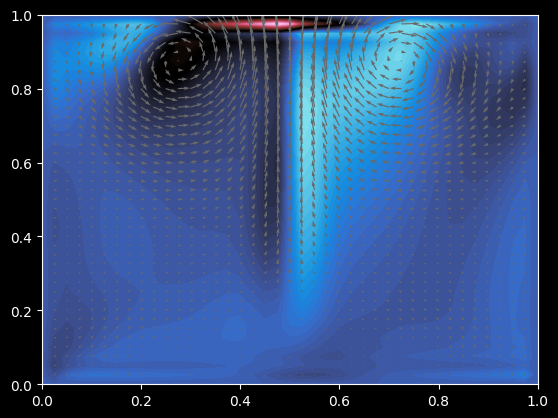

In [ ]:
element_length = DOMAIN_SIZE / (N_POINTS-1)
scalar_shape = (N_POINTS, N_POINTS)
scalar_dof = N_POINTS**2
vector_shape = (N_POINTS, N_POINTS, 2)
vector_dof = N_POINTS**2 * 2 

x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

# "ij" indexing으로 differential equation을 logical하게 하는 용도이다.
# plotting 할때 주의 해야함
X, Y = np.meshgrid(x, y, indexing ="ij")

coordinates = np.concatenate(
    (
        X[..., np.newaxis],
        Y[..., np.newaxis],
    ),
    axis=-1
)

forcing_function_vectorized = np.vectorize(
    pyfunc=forcing_function,
    signature="(),(d)->(d)",
)



plt.style.use("dark_background")
plt.figure(figsize=(5, 5), dpi=160)

velocities_prev = np.zeros(vector_shape)

time_current = 0.0
for i in range(N_TIME_STEPS):
    time_current += TIME_STEP_LENGTH

    forces = forcing_function_vectorized(
        time_current,
        coordinates,
    )

    # (1) Apply Forces
    velocities_forces_applied = (
        velocities_prev
        +
        TIME_STEP_LENGTH
        *
        forces
    )

    # (2) Nonlinear convection (=self-advection)
    velocities_advected = advect(
        field=velocities_forces_applied,
        vector_field=velocities_forces_applied,
    )

    # (3) Diffuse
    velocities_diffused = splinalg.cg(
        A=splinalg.LinearOperator(
            shape=(vector_dof, vector_dof),
            matvec=diffusion_operator,
        ),
        b=velocities_advected.flatten(),
        maxiter=MAX_ITER_CG,
    )[0].reshape(vector_shape)

    # (4.1) Compute a pressure correction
    pressure = splinalg.cg(
        A=splinalg.LinearOperator(
            shape=(scalar_dof, scalar_dof),
            matvec=poisson_operator,
        ),
        b=divergence(velocities_diffused).flatten(),
        maxiter=MAX_ITER_CG,
    )[0].reshape(scalar_shape)

    # (4.2) Correct the velocities to be incompressible
    velocities_projected = (
        velocities_diffused
        -
        gradient(pressure)
    )

    # Advance to next time step
    velocities_prev = velocities_projected

    # Plot
    curl = curl_2d(velocities_projected)
    plt.contourf(
        X,
        Y,
        curl,
        cmap=cmr.redshift,
        levels=100,
    )
    plt.quiver(
        X, 
        Y,
        velocities_projected[..., 0],
        velocities_projected[..., 1],
        color="dimgray",
    )
    plt.draw()
    plt.pause(0.0001)
    plt.clf()
    clear_output(wait=True)
plt.show()